In [ ]:


from training_rl.offline_rl.custom_envs.custom_envs_registration import register_grid_envs
import warnings
from training_rl.offline_rl.load_env_variables import load_env_variables
from training_rl.offline_rl.scripts.visualizations.utils import snapshot_env
from training_rl.offline_rl.custom_envs.utils import Grid2DInitialConfig, InitialConfigCustom2DGridEnvWrapper
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from training_rl.offline_rl.custom_envs.custom_envs_registration import CustomEnv, RenderMode
import gymnasium as gym
from training_rl.offline_rl.behavior_policies.behavior_policy_registry import BehaviorPolicyType
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import \
    create_combined_minari_dataset
from training_rl.offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from training_rl.offline_rl.offline_trainings.policy_config_data_class import TrainedPolicyConfig
from training_rl.offline_rl.offline_policies.policy_registry import PolicyName
from training_rl.offline_rl.offline_trainings.offline_training import offline_training
import torch
from training_rl.offline_rl.offline_trainings.policy_config_data_class import get_trained_policy_path
import os
from training_rl.offline_rl.offline_trainings.restore_policy_model import restore_trained_offline_policy


load_env_variables()

warnings.filterwarnings("ignore")
# ToDo: this should be load automatically
register_grid_envs()

**In this exercise we will test how conservative are the CQL and the BCQ**. 

As mentioned before regularization methods (like CQL) will be a good chooice when you want a more safe behavior for your agent but if you are intreseted in a optimal solution without too much care about safety contrainted methods like BCQ could be the way to go.

### Environment

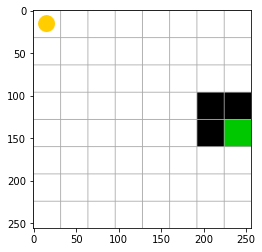

In [12]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete

# Env. Config.
OBSTACLE = ObstacleTypes.horizontal_line_object_8x8
INITIAL_STATE = (0, 0)
FINAL_STATE = (0, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=RenderMode.RGB_ARRAY_LIST), 
                                          env_config=env_2D_grid_initial_config)
snapshot_env(env)

### Configure the two datasets

In [13]:
IDENTIFIER_COMBINED_DATASETS = "_conservative_test"

# Dataset I
#BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_moves_downwards_within_strip
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_moves_downwards_within_strip_and_left
DATA_SET_IDENTIFIER_I = "_move_downwards"
NUM_STEPS_I = 3000

# Dataset II
#BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_eps_greedy_4_0_to_7_7
BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_deterministic_4_0_to_7_7
DATA_SET_IDENTIFIER_II = "_move_deterministic"
NUM_STEPS_II = 300

### Create Minari combined dataset

In [14]:
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_identifiers = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_colected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "combined_dataset",
        env_2d_grid_initial_config = env_2D_grid_initial_config,
)

Dataset Grid_2D_8x8_discrete-data_wall_object_8x8_start_0_0_target_4_7_move_downwards-V0 deleted!
Dataset Grid_2D_8x8_discrete-data_wall_object_8x8_start_0_0_target_4_7_move_deterministic-V0 deleted!
Dataset Grid_2D_8x8_discrete-combined_dataset-V0 deleted!
Number of episodes in dataset I:50, in dataset I:5 and  in the combined dataset: 55


### Rendering behavioral policy 

EXERCISE:

I - Train the following algorithms: CQL, BCQ and DQN
II - Compare the results and extract conclusions.

(
DQN --> BAD
CQL --> better but not optimal
BCQ --> better 
)

III - increase the size of data II

What do you observe?


In [ ]:
# Suboptimal policy
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    behavior_policy_name=BEHAVIOR_POLICY_II,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

### EXERCISE: Train the CQL and BCQ algorithms on the collected dataset and extract conclusions about what do you observe.

### Choose yuor policy

In [15]:
# The model policy to be trained.
POLICY_NAME = PolicyName.cql_discrete


NAME_EXPERT_DATA = config_combined_data.data_set_name
# TrainedPolicyConfig is a handy object that will help us to deal with the policy configuration data.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=NAME_EXPERT_DATA,
    policy_name=POLICY_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    device="cpu",
)

### Training ( If you want to use an already trained policy run the cell below and skip this one !! )

In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
UPDATE_PER_EPOCH = 100

# After every epoch we will collect some test statistics from the policy from NUMBER_TEST_ENVS independent envs.
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None #1626


# Run the training
offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    update_per_epoch=UPDATE_PER_EPOCH,
    restore_training=False,
)

In [ ]:
POLICY_FILE = "policy.pth"
# restore a policy with the same configuration as the one we trained.
policy = restore_trained_offline_policy(offline_policy_config)
# load the weights
name_expert_data = offline_policy_config.name_expert_data
log_name = os.path.join(name_expert_data, POLICY_NAME)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_FILE), map_location="cpu"))


In [ ]:
offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

### Exercise 2:

Let use the same policies as before but let's change the target to (4,7). 

2-a) Use a free obstacle enviroment. What do you think are going to be the results?

2-b) Use the BCQ now with the obstacle call wall_object8x8 (Please, run the next cell to give a look.)
     What do you think is going to happen with the BCQ?

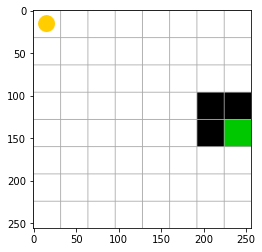

In [6]:
env_2D_grid_initial_config.obstacles = ObstacleTypes.wall_object_8x8
env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=RenderMode.RGB_ARRAY_LIST), 
                                          env_config=env_2D_grid_initial_config)
snapshot_env(env)

